In [39]:
import pandas as pd
import numpy as np
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import LearningRateScheduler
from shutil import copyfile


import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

In [40]:
emotions = ['angry', 'happy', 'relaxed', 'sad']

In [41]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [42]:
train_generator = train_datagen.flow_from_directory('Dataset',
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(128, 128),
                                                    subset='training')

valid_generator = valid_datagen.flow_from_directory('Dataset',
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(128, 128),
                                                    subset='validation')

Found 4000 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


In [43]:
def label_to_index(label):
    label = label.replace(' ', '')
    label = label.replace('[', '')
    label = label.replace(']', '')
    
    index = 0
    for i in label:
        if i == '0':
            index += 1
        if i == '1':
            break

    return index

In [44]:
def show_images(generator, nRows = 1, nCols = 2, WidthSpace = 0.02, HeightSpace = 0.15):
    """
    Plots random num_images images from generator

    Args:
        generator: a generator instance
        nRows: number of rows
        nCols: number of columns
        WidthSpace: width space
        HeightSpace: height space
    """
    global emotions
    gs = gridspec.GridSpec(nRows, nCols)     
    gs.update(wspace=WidthSpace, hspace=HeightSpace)
    
    images, labels = generator.next()
    labels = labels.astype('int32')
    num_images = nRows * nCols
    
    
    plt.figure(figsize=(20,10))
    
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(gs[i])
        plt.imshow(image)
        label = label_to_index(str(label))
        plt.title(emotions[label])
        if i == num_images - 1:
            break
    plt.show()
        

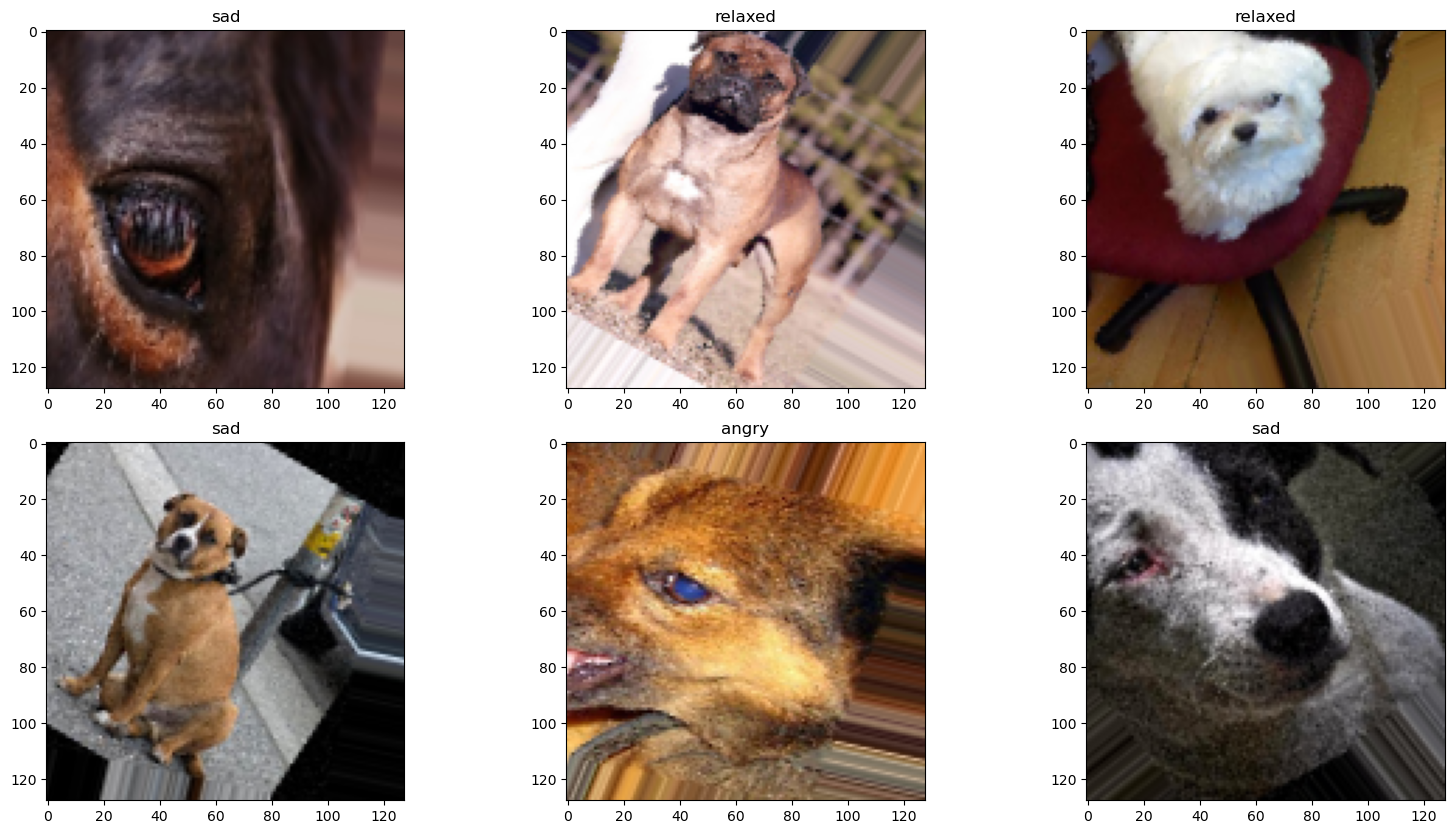

In [45]:
show_images(train_generator, 2, 3)

In [46]:
model = Sequential()

# Inputs and rescaling
model.add(Rescaling(scale=1./255, input_shape=(128, 128, 3)))

# Convolutional block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

# Convolutional block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

# Convolutional layres 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

# Convolutional block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())

# Dense block
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 128)       147584    
                                                      

In [47]:
def scheduler(epoch, learning_rate):
    if epoch < 20:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.2)

callback = LearningRateScheduler(scheduler)

In [48]:
history = model.fit_generator(train_generator,    
                    validation_data = valid_generator,
                    epochs=25, callbacks=[callback])

Epoch 1/25
40/40 [==============================] - 320s 8s/step - loss: 1.3864 - accuracy: 0.2405 - lr: 1.0000e-04
Epoch 2/25
22/40 [===============>..............] - ETA: 2:18 - loss: 1.3863 - accuracy: 0.2436

KeyboardInterrupt: 